In [1]:
%matplotlib inline

In [2]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa, three_to_one
from matplotlib import pyplot as plt
from scipy import stats
import scipy.spatial
import pandas as pd
import numpy as np
import glob
import shutil

import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 12

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica Neue'
matplotlib.rcParams['font.weight']='ultralight'
matplotlib.rcParams['axes.axisbelow'] = True


In [4]:
from supporting_functions import *

# Read PDBs and convert them to contact distance matrices

In [7]:
def process_residue(residue):
    '''
    Processes a single residue to determine the coordinates of the alpha-carbon
    and the sidechain center-of-mass. Also checks for missing atoms in a
    residue.
    (This is directly from Ben's code with slight modifications for Glycine)--AJH
    '''
    output_dict = {}
    atoms_seen = []
    # Convert three letter amino acid to one letter
    try:
        output_dict['amino_acid'] = three_to_one(residue.resname)
    except KeyError:
        return 'Error'
    
    # Grab residue number AND any insertion site labeling (11A, 11B, etc.)
    output_dict['residue'] = str(residue.get_id()[1]) + \
                             residue.get_id()[2].strip()
    output_dict['chain'] = residue.get_full_id()[2]
    try:
        int(output_dict['residue'])
    except:
        return 'Error'
    
    # Coordinates of all sidechain atoms in this residue
    sidechain_coords = []
    for atom in residue:
        atoms_seen.append(atom.name)
        if atom.name == 'CA':
            # Save alpha-carbon coordinates
            output_dict['CA'] = atom.get_coord()
            
        ######################################################
        #AJH: code to add CB and to make exceptions for Glycine
            if residue.resname=='GLY':
                output_dict['CB'] = atom.get_coord()
                
        if atom.name == 'CB':
            # Save beta-carbon coordinates
            output_dict['CB'] = atom.get_coord()
        ######################################################

        if atom.name not in ['C', 'CA', 'O', 'N']:
            # Must be a sidechain atom...
            sidechain_coords.append(atom.get_coord())

    if 'CA' not in output_dict or 'CB' not in output_dict:
        return 'Error'
    
    for mainchain_atom in ['N', 'C', 'O']:
        # Warn about any missing mainchain atoms
        if mainchain_atom not in atoms_seen:
            return 'Error'

    if len(sidechain_coords) == 0:
        if output_dict['amino_acid'] == 'G':
            sidechain_coords.append(output_dict['CA'])
        else:
            return 'Error'

    # Calculate side chain center of mass
    output_dict['SCcenter'] = sum(sidechain_coords)/\
                                      len(sidechain_coords)
    
    return output_dict


def unit_vector(vector):
    ''' Returns the unit vector of the vector.'''
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    '''
    Returns the angle in radians between vectors 'v1' and 'v2':
    
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    '''

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

**First load PDB files and get a.a. sequences**

**This should be a "cleaned" PDB file of the type that is used directly for simulations, which is to say properly numbered 1...len(amino acid sequence), no random atoms, single chain, etc.**

In [41]:
error_pdbs = [] ### Keep track of pdb's where weird things happened to investigate
for infile_loc in glob.glob('../Data/PDBs/*.clean.pdb')[:]: #Iterating through a bunch of files
    print("###################################################")
    print(infile_loc)
    print("###################################################")
    prot_name = infile_loc.split('/')[-1].replace('.clean.pdb', '')
    print(prot_name)
    structure = PDBParser().get_structure(prot_name, infile_loc)

    ###Get residue coordinates
    residues = []
    for residue in structure.get_residues():
        if is_aa(residue):
            temp = process_residue(residue)
            residues.append(temp)
    if 'Error' in residues:
        error_pdbs.append(infile_loc)
        continue
    residues = sorted(residues, key=lambda x: int(x['residue']))
    
    ###Get the overall amino acid sequence. Know there are much more efficient ways than this.
    aa_seq_from_structure = sorted([(i['amino_acid'], int(i['residue'])) for i in residues], key=lambda x: x[1])
    aa_seq_from_structure = ''.join([i[0] for i in aa_seq_from_structure])
    print('Protein length is {} amino acids'.format(len(aa_seq_from_structure)))
    print(aa_seq_from_structure)
    
    for calculation in ['CA', 'SCcenter', 'CB']: #Writing three different contact matrices
        print(calculation)
        numbering = list(range(1, len(aa_seq_from_structure)+1))
        df_contacts = pd.DataFrame(index=numbering, columns=numbering) ###Set up empty df for contact dists
        for i, residue in enumerate(residues):
            for j, other_residue in enumerate(residues):
                contact_dist = scipy.spatial.distance.euclidean(residue[calculation],other_residue[calculation])
                df_contacts.set_value(i+1, j+1, contact_dist)
        contact_file = infile_loc.replace('/PDBs/', '/Contact_matrices/')
        contact_file = contact_file.replace('.clean.pdb', '_{}_contacts.csv'.format(calculation))
        df_contacts.to_csv(contact_file)
        
        ###Separate code to get a matrix of side chain angles
        if calculation == 'CA':
            print('Working on angles')
            numbering = list(range(1, len(aa_seq_from_structure)+1))
            df_angles = pd.DataFrame(index=numbering, columns=numbering)
            for i, residue in enumerate(residues):
                for j, other_residue in enumerate(residues):
                    if residue['amino_acid'] != 'G' and residue != other_residue:
                        point1 = np.array(other_residue['CA'])
                        point2 = np.array(residue['SCcenter'])
                        vertex = np.array(residue['CA'])
                        v1 = point1 - vertex
                        v2 = point2 - vertex
                        angle = angle_between(v1, v2)
                    else:
                        angle = np.nan
                    df_angles.set_value(i+1, j+1, angle)
            angles_file = infile_loc.replace('/PDBs/', '/Contact_matrices/')
            angles_file = angles_file.replace('.clean.pdb', '_{}_angles.csv'.format(calculation))
            df_angles.to_csv(angles_file)

###################################################
../Data/PDBs/1mla.clean.pdb
###################################################
1mla
Protein length is 305 amino acids
QFAFVFPGQGSQTVGMLADMAASYPIVEETFAEASAALGYDLWALTQQGPAEELNKTWQTQPALLTASVALYRVWQQQGGKAPAMMAGHSLGEYSALVCAGVIDFADAVRLVEMRGKFMQEAVPEGTGAMAAIIGLDDASIAKACEEAAEGQVVSPVNFNSPGQVVIAGHKEAVERAGAACKAAGAKRALPLPVSVPSHCALMKPAADKLAVELAKITFNAPTVPVVNNVDVKCETNGDAIRDALVRQLYNPVQWTKSVEYMAAQGVEHLYEVGPGKVLTGLTKRIVDTLTASALNEPSAMAAAL
CA
Working on angles
SCcenter
CB
###################################################
../Data/PDBs/1o89.clean.pdb
###################################################
1o89
Protein length is 320 amino acids
LQALLLEQQTLASVQTLDESRLPEGDVTVDVHWSSLNYKDALAITGKGKIIRNFPMIPGIDFAGTVRTSEDPRFHAGQEVLLTGWGVGENHWGGLAEQARVKGDWLVAMPQGLDARKAMIIGTAGFTAMLCVMALEDAGVRPQDGEIVVTGASGGVGSTAVALLHKLGYQVVAVSGRESTHEYLKSLGASRVLPRDEFAESRPLEKQVWAGAIDTVGDKVLAKVLAQMNYGGCVAACGLAGGFTLPTTVMPFILRNVRLQGVDSVMTPPERRAQAWQRLVADLPESFYTQAAKEISLSEAPNFAEAIINNQIQGRTLVK

In [ ]:
print(error_pdbs)

In [ ]:
for pdb_file in error_pdbs:
    shutil.move(pdb_file, pdb_file.replace('/PDBs/', '/PDBs/unknown_errors/'))

# Some figures to look at differences between contact definitions for an example protein/s
**First import a contacts csv**

In [45]:
chain_cutoff = 12
df_contacts_dict = {}
metrics = ['CA', 'CB', 'SCcenter']
for metric in metrics:
    df_contacts_dict[metric] = {}

CA_distance_cutoff = 8
total_contacts_via_CA = {}
CB_distance_cutoffs = {}
SC_distance_cutoffs = {}

for metric in metrics[:]:
    for contact_file in glob.glob('../Data/Contact_matrices/*_{}_contacts.csv'.format(metric))[:]:
        prot_name = contact_file.split('/')[-1].split('_')[0]
        total_contacts = 0
        cutoff=0
        df_contacts = pd.read_csv(contact_file, index_col=0)
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, 12)
        if metric == 'CA':
            total_contacts = df_contacts_stack[df_contacts_stack['distance']<CA_distance_cutoff]['distance'].count()
            total_contacts_via_CA[prot_name] = total_contacts
        else:
            temp = df_contacts_stack.sort_values('distance')[:total_contacts_via_CA[prot_name]]
            cutoff = temp.iloc[total_contacts_via_CA[prot_name]-1]['distance']
            if metric == 'CB':
                CB_distance_cutoffs[prot_name] = cutoff
            elif metric == 'SCcenter':
                SC_distance_cutoffs[prot_name] = cutoff
        df_contacts_dict[metric][prot_name] = (df_contacts, df_contacts_stack)

**Look at all contacts as a heatmap for an example**

In [47]:
prot_name = '3ip0'
vmin = 0
vmax = 42
metric = 'SCcenter'
df_contacts = df_contacts_dict[metric][prot_name][0]

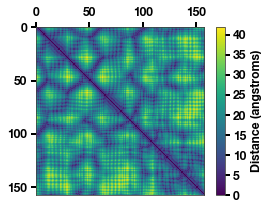

In [48]:
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(df_contacts.as_matrix(), vmin=vmin, vmax=vmax)
ax.grid(False)
cbar = fig.colorbar(cax)
# cbar.set_label(r'C$\alpha$ distance (angstroms)', fontsize=12)
# cbar.set_label('Side-chain center\ndistance (angstroms)', fontsize=12)
cbar.set_label('Distance (angstroms)', fontsize=12)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)

plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('{}/{}_{}_contacts.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

**Apply a threshold to only show contacts below a certain distance**

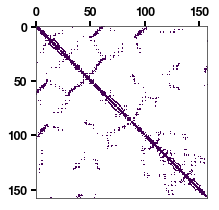

In [49]:
distance_threshold = 8.0
binarized_contacts = df_contacts[df_contacts <= distance_threshold]
binarized_contacts.mask(binarized_contacts <= distance_threshold, other = 1, inplace=True)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binarized_contacts.as_matrix())
ax.grid(False)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('{}/{}_{}_binary.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

**Apply a filter to remove pairs that are closer than X primary a.a's away from one another**

In [ ]:
for index in binarized_contacts.index:
    for col in binarized_contacts.columns:
        if abs(index-col) < 12:
            binarized_contacts.set_value(index, col, np.nan)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binarized_contacts.as_matrix())
ax.grid(False)
ax.xaxis.tick_top()
plt.tick_params(labelsize=12)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()
plt.savefig('{}/{}_{}_binary_truncated.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

# Coupling matrices examples
**Think that these are for presentation purposes only**

In [ ]:
df_couplings = pd.read_csv('../Data/Empirical_couplings/rp55/3ip0_312_rp55.couplings', sep=' ', header=None)
df_couplings_pivot = df_couplings.pivot(index=0, columns=2, values=5).fillna(0)+df_couplings.pivot(index=2, columns=0, values=5).fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(df_couplings_pivot.as_matrix())
ax.grid(False)
cbar = fig.colorbar(cax)
cbar.set_label('Coupling score', fontsize=12)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)

plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('{}/{}_{}_couplings.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

In [ ]:
a, b, c = process_couplings_df(df_couplings, df_contacts, 12)

In [ ]:
threshold = min(c.sort_values('couplings', ascending=False)[:max(c['aa2_loc'])]['couplings'])

df_couplings_pivot = c.pivot(index='aa1_loc', columns='aa2_loc', values='couplings').fillna(0)+\
            c.pivot(index='aa2_loc', columns='aa1_loc', values='couplings').fillna(0)
binary = df_couplings_pivot[df_couplings_pivot > threshold]
binary.mask(binary > threshold, other=1, inplace=True)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binary.as_matrix())
ax.grid(False)
ax.xaxis.tick_top()
# ax.set_yticks([])
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('{}/{}_{}_couplings_binary.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

# Lots of proteins

In [ ]:
np.median(list(CB_distance_cutoffs.values())), np.median(list(SC_distance_cutoffs.values()))

In [ ]:
fig, ax = plt.subplots()
ax.hist(list(SC_distance_cutoffs.values()))
ax.set_xlabel('Side-chain center threshold distance (angstroms)\nto achieve an equivalent number of contacts')
ax.set_ylabel('Counts')

In [ ]:
metrics = ['CA', 'SCcenter']
ca_dist = 8
rho_vals = []
intersection_vals = []
for prot_name in list(df_contacts_dict['CA'].keys())[:]:
    first_contacts = df_contacts_dict[metrics[0]][prot_name][1].copy()
    second_contacts = df_contacts_dict[metrics[1]][prot_name][1].copy()
    assert all(first_contacts.index == second_contacts.index)
    assert all(first_contacts['aa1_loc'] == second_contacts['aa1_loc'])
    assert all(first_contacts['aa2_loc'] == second_contacts['aa2_loc'])
    first_contacts_trunc = first_contacts[first_contacts['distance'] <= 8]
    totals = len(first_contacts_trunc.index)
    second_contacts_trunc = second_contacts.sort_values('distance')
    second_contacts_trunc = second_contacts_trunc.head(totals)
    second_contacts_trunc.sort_index(inplace=True)
    intersection = len(list(set(first_contacts_trunc.index) & set(second_contacts_trunc.index)))
    rho, pval = stats.spearmanr(first_contacts['distance'], second_contacts['distance'])
    rho_vals.append(rho)
    intersection_vals.append(intersection/totals*100)

In [ ]:
print(len(rho_vals), np.mean(rho_vals))
print(len(intersection_vals), np.mean(intersection_vals))
fig, ax = plt.subplots(figsize=(3,2.25))
ax.hist(rho_vals,20, color='gray')
ax.set_xlabel(r"Spearman's $\rho$")
ax.set_ylabel('Counts')
plt.savefig('{}/contact_correlation_hist.pdf'.format(figs_dir), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3,2.25))
ax.hist(intersection_vals,20, color='gray')
ax.set_xlabel(r"Contacts % agreement")
ax.set_ylabel('Counts')
plt.savefig('{}/contact_intersection_hist.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
example_prot = '3ip0'
metrics = ['CA', 'SCcenter']
ca_dist = 8

for prot_name in list(df_contacts_dict['CA'].keys())[:]:
    if prot_name != example_prot:
        continue
    first_contacts = df_contacts_dict[metrics[0]][prot_name][1].copy()
    second_contacts = df_contacts_dict[metrics[1]][prot_name][1].copy()
    assert all(first_contacts.index == second_contacts.index)
    assert all(first_contacts['aa1_loc'] == second_contacts['aa1_loc'])
    assert all(first_contacts['aa2_loc'] == second_contacts['aa2_loc'])
    first_contacts_trunc = first_contacts[first_contacts['distance'] <= 8]
    totals = len(first_contacts_trunc.index)
    second_contacts_trunc = second_contacts.sort_values('distance')
    second_contacts_trunc = second_contacts_trunc.head(totals)
    second_contacts_trunc.sort_index(inplace=True)
    intersection = len(list(set(first_contacts_trunc.index) & set(second_contacts_trunc.index)))
    rho, pval = stats.spearmanr(first_contacts['distance'], second_contacts['distance'])


In [ ]:
plot_df = pd.merge(first_contacts, second_contacts, left_index=True, right_index=True)

In [ ]:
max_axis_lims = 14
x_cutoff = ca_dist
y_cutoff = SC_distance_cutoffs[example_prot]
textstr = r'$\rho={0:2.2f}$'.format(rho)
props = dict(boxstyle='square', facecolor='white', edgecolor='lightgray', alpha=1)

fig, ax = plt.subplots(figsize=(4,3))
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, markersize=2, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, markersize=2, alpha=0.5, label=r'Side-chain')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, markersize=2, alpha=0.3, label=r'Both')
# legend = ax.legend(ncol=2, bbox_to_anchor=(0.05, 1.02, 1., .102), fontsize=12, title='Contact classification')
# legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Contact classification', markerscale=6)
# legend.get_title().set_fontsize('12') #legend 'Title' fontsize
ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('{}/{}_distance_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, alpha=0.5, label=r'Side-chain')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, alpha=0.3, label=r'Both')
# legend = ax.legend(ncol=2, bbox_to_anchor=(0.05, 1.02, 1., .102), fontsize=12, title='Contact classification')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Contact classification', markerscale=2)
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.set_xlim(1,max_axis_lims)
ax.set_ylim(1,max_axis_lims)

textstr1 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='steelblue', alpha=1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr2 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='darkorange', alpha=1)
ax.text(0.75, 0.13, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr3 = r'$n={}$'.format(intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='purple', alpha=1)
ax.text(0.05, 0.13, textstr3, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('{}/{}_contact_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

In [ ]:
max_axis_lims = 14
x_cutoff = ca_dist
y_cutoff = SC_distance_cutoffs[example_prot]
textstr = r'$\rho={0:2.2f}$'.format(rho)
props = dict(boxstyle='square', facecolor='white', edgecolor='lightgray', alpha=1)

fig, all_ax = plt.subplots(nrows=1, ncols=2,figsize=(8,3))
ax = all_ax[0]
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, markersize=2, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, markersize=2, alpha=0.5, label=r'Side-chain center')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, markersize=2, alpha=0.3, label=r'Both')

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax = all_ax[1]
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, alpha=0.5, label=r'Side-chain center')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, alpha=0.3, label=r'Both')
legend = ax.legend(ncol=4, bbox_to_anchor=(-0.25, 1.02, 1., .102), fontsize=12, title='Contact classification', markerscale=2)
# legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Contact classification', markerscale=2)
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
# ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.set_xlim(1,max_axis_lims)
ax.set_ylim(1,max_axis_lims)

textstr1 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='steelblue', alpha=1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr2 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='darkorange', alpha=1)
ax.text(0.75, 0.15, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr3 = r'$n={}$'.format(intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='purple', alpha=1)
ax.text(0.05, 0.15, textstr3, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig('{}/{}_scatter_combined.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

# only used for presentation

In [ ]:
max_axis_lims = 14
x_cutoff = ca_dist
y_cutoff = SC_distance_cutoffs[example_prot]
textstr = r'$\rho={0:2.2f}$'.format(rho)
props = dict(boxstyle='square', facecolor='white', edgecolor='lightgray', alpha=1)

fig, all_ax = plt.subplots(figsize=(4,3))
ax = all_ax
# ax = all_ax[0]
ax.plot(plot_df['distance_x'], plot_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.2, label='_nolegend_')

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.savefig('{}/{}_pres_example_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

fig, all_ax = plt.subplots(figsize=(4,3))
ax = all_ax
# ax = all_ax[0]
ax.plot(plot_df['distance_x'], plot_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=5, alpha=0.2, label='_nolegend_')

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.set_xlim(0,15)
ax.set_ylim(0,15)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig('{}/{}_pres_example_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')




fig, all_ax = plt.subplots(figsize=(4,3))
ax = all_ax
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, alpha=0.5, label=r'Side-chain center')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, alpha=0.3, label=r'Both')
# legend = ax.legend(ncol=4, bbox_to_anchor=(-0.25, 1.02, 1., .102), fontsize=12, title='Contact classification', markerscale=2)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Contact classification', markerscale=2)
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.set_xlim(1,max_axis_lims)
ax.set_ylim(1,max_axis_lims)

textstr1 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='steelblue', alpha=1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr2 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='darkorange', alpha=1)
ax.text(0.75, 0.15, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr3 = r'$n={}$'.format(intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='purple', alpha=1)
ax.text(0.05, 0.15, textstr3, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig('{}/{}_pres_ex_scatter_zoom.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

# Scratch

In [ ]:
from Bio import PDB


clean_pdb_file = '../Data/PDBs/1pv1.clean.pdb'
pdb_io = PDB.PDBIO()
pdb_parser = PDB.PDBParser()
structure = pdb_parser.get_structure(" ", clean_pdb_file)

if len(structure) != 1:
    print('THERE APPEARS TO BE MORE THAN ONE MODEL IN THIS STRUCTURE BEHAVIOR OF PRORAM IS UNKNOWN ({}). EXITING'.format(clean_pdb_file))

chain_counts = {}
for model in structure:
    for chain in model:
        print(chain.id)
        new_number = 1 
        for i, residue in enumerate(chain.get_residues()):
            res_id = list(residue.id)
            if res_id[1] != new_number:
                res_id[1] = new_number
                residue.id = tuple(res_id)
            new_number+=1
        chain_counts[chain.id] = new_number

chain_to_keep = sorted(chain_counts.items(), key=lambda x: x[1])
chain_to_keep = str(chain_to_keep[-1][0])
print('##keeping {}'.format(chain_to_keep))

# for model in structure:
#     for chain in model:
#         print(chain.id)
#         if chain.id != chain_to_keep:
#             print(chain.id)
#             model.detach_child(chain.id)
#         else:
#             print('wtf {}'.format(chain.id))
# pdb_io.set_structure(structure)


In [ ]:
for model in structure:
    for chain in model:
        print(chain.id)

In [ ]:
to_delete = ['A', 'B', 'D']
for i,j in enumerate(to_delete):
    structure[0].detach_child(to_delete[i])

In [ ]:
for model in structure:
    for chain in model:
        print(chain.id)

In [ ]:
stringy = 'ATGCAAAG'
listy = [stringy[i:i+3] for i in range(0, len(stringy), 3)]

In [ ]:
listy